### Potential outcomes and the propensity score

Sources:
- Causal Inference Mixtape 
- Imbens/Rubin 2015 
- Imbens review article JEL
- Dehejia/Wahba 2002 (DW2002). https://business.baylor.edu/scott_cunningham/teaching/dehejia-and-wahba-2002.pdf


Context
- Labor market policy: training unemployed workers to re-integrate them in the labor market
- What are the effects of such training on the workers?
- Unemployed workers are not a random sample of the population
    - Normally we only have observational data (ie, labor market data, information on job training)
- Lalonde 1986: conducts experiment among unemployed, and compares to existing methods with observational data
- He found that existing methods performed poorly in recovering the true experimental effect from the observational data only
- Dehejia/Wahba repeated Lalonde's analysis, but used (at the time) cutting-edge matching methods

In [1]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import statsmodels.formula.api as smf 

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from helpers import load_data
from plotting import make_histogram

### Load data 

In [2]:
nsw_stacked = load_data()

In [3]:
nsw_stacked.describe()

,treat,age,educ,black,hisp,marr,nodegree,earn74,earn75,earn78,randomised,unemp74,unemp75
count,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000,16437.000000
mean,0.011255,33.012592,11.977916,0.094117,0.072458,0.697025,0.308998,13694.237305,13318.517578,14588.224609,0.027073,0.136217,0.123928
std,0.105495,11.030899,2.862478,0.292000,0.259253,0.459558,0.462094,9675.637695,9372.831055,9702.608398,0.162301,0.343029,0.329509
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,11.000000,0.000000,0.000000,0.000000,0.000000,3644.236084,3695.896973,5088.759766,0.000000,0.000000,0.000000
50%,0.000000,31.000000,12.000000,0.000000,0.000000,1.000000,0.000000,14655.320312,14109.530273,15962.400391,0.000000,0.000000,0.000000
75%,0.000000,42.000000,13.000000,0.000000,0.000000,1.000000,1.000000,23360.339844,22703.080078,25564.669922,0.000000,0.000000,0.000000
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,39570.679688,25243.550781,60307.929688,1.000000,1.000000,1.000000


Below we see the cross-tabulation of `randomised` and `treat`:
- randomised = 1 are the persons in the original randomised experiment 
- randomised = 0 are the persons from an observational data set (Current Population Survey, CPS)
- We can compare the cell (treat = 1, randomised = 1) to the cell (treat = 0, randomised = 0) or to the cell (treat = 0, randomised = 1)

In [4]:
pd.crosstab(nsw_stacked["treat"], nsw_stacked["randomised"])

randomised,0,1
treat,,
0.0,15992,260
1.0,0,185


### Naive difference in means
- We compare (treat = 1, randomised = 1)  to (treat = 0, randomised = 0) 

In [5]:
mask_treat = (nsw_stacked["treat"] == 1) & (nsw_stacked["randomised"] == 1)
mask_control = (nsw_stacked["treat"] == 0) & (nsw_stacked["randomised"] == 0)

yvar = "earn78"
y1 = nsw_stacked.loc[mask_treat, yvar].mean()
y0 = nsw_stacked.loc[mask_control, yvar].mean()

te1 = y1 - y0


print(f"The non-experimental difference in raw means is {te1:.2f}")

The non-experimental difference in raw means is -8497.52


This number is the same as in Dehejia/Wahba 2022, table 2, row 2, second-last column

### Experimental estimate

We *do* have the experimental data, so let's see the estimate here.

In [6]:
mask_treat = (nsw_stacked["treat"] == 1) & (nsw_stacked["randomised"] == 1)
mask_control = (nsw_stacked["treat"] == 0) & (nsw_stacked["randomised"] == 1)

yvar = "earn78"
y1 = nsw_stacked.loc[mask_treat, yvar].mean()
y0 = nsw_stacked.loc[mask_control, yvar].mean()

te1 = y1 - y0


print(f"The experimental difference in raw means is {te1:.2f}")

The experimental difference in raw means is 1794.34


### Selection bias
People that are eligible for the training program are different from the average person in the CPS. They are less attached to the labor market, younger, less educated etc. Therefore, comparing their earnings to the average person in the CPS suffers from selection bias.

### Why not just a linear regression?
- We could just run a regression and control for the other observed characteristics
- But the potential outcome approach has the following benefits:
    - It makes us more aware of the required assumptions 
    - In some cases, regression may heavily interpolate between groups; using the methods discussed here puts some more hurdles that prevent us from blindly doing this
- We can select the covariates $X$ without looking at the outcome $Y$
    - This is also the foundation of the recent methods on "doubly-robust learning"
    - Perhaps this limits researcher degrees of freedom more than linear regression, where it's easy to search for "the right" specification
- Statistically (in terms of robustness and efficiency), regression does not necessarily dominate (see Imbens 2020, section 3.5)

### Let's ignore the experimental controls and try to improve our observational estimate with the propensity score

In [7]:
drop = (nsw_stacked["randomised"] == 1) & (nsw_stacked["treat"] == 0)
nsw_stacked = nsw_stacked.loc[~drop, :].copy()

mask_treat = nsw_stacked["treat"] == 1
mask_control = nsw_stacked["treat"] == 0

N_treat = nsw_stacked.loc[mask_treat, :].shape[0]
N_control = nsw_stacked.loc[mask_control, :].shape[0]

assert N_treat + N_control == nsw_stacked.shape[0], "some units got lost"


#### Estimate the propensity score, following DW2002

In [8]:
logit_nsw = smf.glm(formula="""treat ~ age + I(age**2) + I(age**3) + educ + I(educ**2) +
                    marr + nodegree + black + hisp + earn74 + earn75
                    + unemp74 + unemp75 + I(educ*earn74)""", 
                    family=sm.families.Binomial(),
                   data=nsw_stacked).fit()

nsw_stacked['pscore'] = logit_nsw.predict(nsw_stacked)

In [9]:
vars_to_compare = ["pscore", "age", "nodegree", "earn75"]
print(nsw_stacked.loc[mask_treat, vars_to_compare].describe())
print(nsw_stacked.loc[mask_control, vars_to_compare].describe())


           pscore         age    nodegree        earn75
count  185.000000  185.000000  185.000000    185.000000
mean     0.425357   25.816216    0.708108   1532.055420
std      0.307691    7.155019    0.455867   3219.250732
min      0.001061   17.000000    0.000000      0.000000
25%      0.132217   20.000000    0.000000      0.000000
50%      0.400199   25.000000    1.000000      0.000000
75%      0.670616   29.000000    1.000000   1817.284058
max      0.938455   48.000000    1.000000  25142.240234
             pscore           age      nodegree        earn75
count  1.599200e+04  15992.000000  15992.000000  15992.000000
mean   6.647637e-03     33.225239      0.295835  13650.803711
std    4.166721e-02     11.045216      0.456432   9270.403320
min    1.176785e-09     16.000000      0.000000      0.000000
25%    1.927808e-05     24.000000      0.000000   4398.823242
50%    1.187188e-04     31.000000      0.000000  14557.110352
75%    9.633719e-04     42.000000      1.000000  22923.736816


**Comparing propensity scores between treated and control groups**

The propensity scores are highly imbalanced, and there are a lot of units in the control group whose propensity score is below the minimum in the treatment group.
Since these units will not be contribute information to the estimation (they are not good "counterfactuals" because of their low propensity score), we drop them, like Dehejia/Wahba also did.

**Other notes: Comparing control group to DW2002**
- Same number of observations
- For the control group, the mean propensity score differs from DW2002 (table 2, row 2).
- But the other 3 variables displayed have the same means.
- Thus, somehow the propensity score is misspecified relative to the original paper, but I don't know why.
- (But the propensity scores for treatment and controls are the same as in Cunningham's book)

In [10]:
nsw_stacked.shape

(16177, 15)

In [11]:
nsw_stacked.loc[nsw_stacked["treat"] == 0].shape

(15992, 15)

In [12]:
pscore_threshold = nsw_stacked.loc[mask_treat, "pscore"].min()
mask_pscore_threshold = nsw_stacked["pscore"] >= pscore_threshold

nsw_stacked = nsw_stacked.loc[mask_pscore_threshold, :].copy()

# re-define the masks
mask_treat = (nsw_stacked["treat"] == 1) 
mask_control = (nsw_stacked["treat"] == 0)


display(sum(mask_control))
display(15992 - sum(mask_control)) # this should be 11168 (DW002) or 12611 (DW1999)


3856

12136

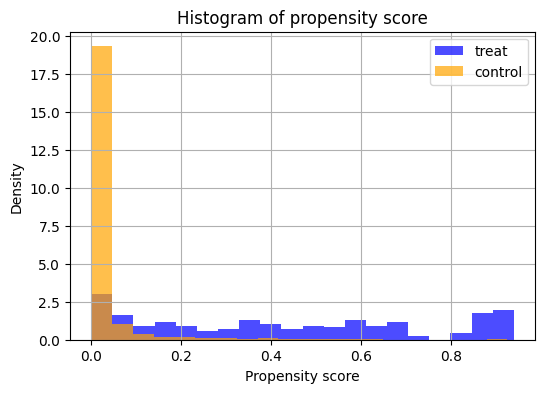

In [13]:
plot_map = {
    "treat": {
        "mask": mask_treat,
        "color": "blue"
    },
    "control": {
        "mask": mask_control,
        "color": "orange"
    }
}

make_histogram(nsw_stacked, plot_map, "Propensity score")

A note on assessing balance
- Advantages of using propensity score to assess balance
    - One-dimensional summary of balance 
    - At values of propensity score with many treated but few control units, the risk of extrapolation is higher ("common support")
- Disadvantages
    - Makes assumptions about the functional form 
- Alternatively, we can plot differences in means, normalized variances and overlap in the tails to compare the groups (see below)


Note that unconfoundedness $\Rightarrow$ balance, so NOT balance $\Rightarrow$ NOT unconfoundedness. But balance is not sufficient for unconfoundedness.

So we have this huge imbalance. How can we fix it? 


**How can we use the propensity score**
- Reweighting 
- Subclassification
- Matching on the propensity score 

Imbens/Rubin prefer subclassification over reweighting because 
- propensity score is estimated with noise, and this enters the denominator in the reweighting schemes, creating bias 
- subclassification has smaller sampling variance because it smoothes over extreme values of the propensity score


We'll only do matching, and match on the log odds ratio instead of the propensity score directly
- The reason has to do with how we think the potential outomes are related to the propensity score
- In particular, whether the potential outcomes are linear in the LPS or in the propensity score 
- See Imbens/Rubin (2015), p. 343.

In [14]:
pscore = nsw_stacked.loc[:, "pscore"].copy()
lps = np.log(pscore / (1 - pscore))
nsw_stacked.loc[:, "lps"] = lps

### Matching on the propensity score

In [15]:

df_treated = nsw_stacked.loc[mask_treat, :]
df_controls = nsw_stacked.loc[mask_control, :]


assert df_treated.index.is_unique
assert df_controls.index.is_unique

df_treated = df_treated.reset_index()
df_controls = df_controls.reset_index()

In [16]:
# we'll use the indexes for tracking the matches
treated = df_treated.loc[:, ["index", "lps"]].to_numpy() # we'll use the index to keep track of the 
controls = df_controls.loc[:, ["index", "lps"]].to_numpy()

# sort from highest to lowest lps
treated = treated[treated[:, 1].argsort()[::-1]] #https://stackoverflow.com/questions/26984414/efficiently-sorting-a-numpy-array-in-descending-order

display(controls.shape)

(3856, 2)

In [17]:
# matching without replacement
matched = []
k = 1 # number of matched control units
for idx_treat in range(N_treat):
    distance = (treated[idx_treat, 1] - controls[:, 1])**2
    idx_min = np.argsort(distance)[:k]  # index of the min 
    idx_ctrl = controls[idx_min][:, 0] # index of the matched control

    # update the pool of controls: drop the matched unit
    mask = np.full(distance.shape, True)
    mask[idx_min] = False
    controls = controls[mask, ...]
    
    # add the matched control index to matched_controls
    # matched += [(int(x), idx_treat) ]
    matched += [(int(x), idx_treat) for x in idx_ctrl]

In [18]:
matched = pd.DataFrame(np.array(matched), columns=["idx_ctrl", "idx_treat"])
mask_pscore_control = df_controls["index"].isin(matched["idx_ctrl"]) 
display(sum(mask_pscore_control))
display(df_treated.shape)

185

(185, 17)

In [19]:
df_controls.loc[mask_pscore_control, vars_to_compare].describe()

,pscore,age,nodegree,earn75
count,185.000000,185.000000,185.000000,185.000000
mean,0.298792,25.545946,0.616216,1781.612793
std,0.218909,8.018274,0.487626,3396.027588
min,0.001062,16.000000,0.000000,0.000000
25%,0.132049,19.000000,0.000000,0.000000
50%,0.259063,24.000000,1.000000,0.000000
75%,0.411690,30.000000,1.000000,2225.371094
max,0.923979,55.000000,1.000000,20268.240234


In [20]:
y1 = df_treated.loc[:, yvar].mean()
y0 = df_controls.loc[mask_pscore_control, yvar].mean()
te_pscore = y1 - y0
print(f"Estimated treatment effect: {te_pscore:.2f}")


Estimated treatment effect: 1109.70


#### Differences to DW2002

- We get closer to the true causal effect, but are still quite far away
- DW2002 performed much better
- Our estimate is much smaller than theirs. 
- Control group has different means across the variables displayed above, indicating that they are different set from the control units in DW2002
- Other things
    - no indication here: https://cameron.econ.ucdavis.edu/mmabook/mma25p1treatment.txt
    - double-checked the propensity score in R, but the formula should be correct


#### Exercise
Match more than one control unit to each treated unit. What happens? What are the trade-offs here?

### Conclusion
- Excitement about propensity score after DW's work
- But economists are almost always concerned about selection on unobservables, rather than on observables
- That's why quasi-experimental methods (difference-in-difference, regression discontinuity) are more popular
- Potential outcomes framework remains useful for these methods, and matching can be combined with some of these methods too.

### Appendix: Assessing balance

As expected, matching on the propensity score makes the treated and control groups much more similar on the pre-treatment variables. 

We can assess overlap across variables as follows (Imbens/Rubin, section 14.2)
- differences in means, normalized by the standard deviation 
- difference in the log of the standard deviations
- overlap in the tails

These statistics illustrate again the problem of "imputing the counterfactuals", and the distributions of the pre-treatment variables should be as similar as possible between treatment and control groups.

In [21]:
from helpers import compute_balancing_stats
from plotting import plot_balance

In [22]:
diff_means_norm, diff_log_stds = compute_balancing_stats(
    xvars=["age", "educ", "black", "hisp", "marr", "nodegree", "earn75", "unemp75"],
    treated=df_treated,
    control_prematch=df_controls,
    control_postmatch=df_controls.loc[mask_pscore_control, :]
)

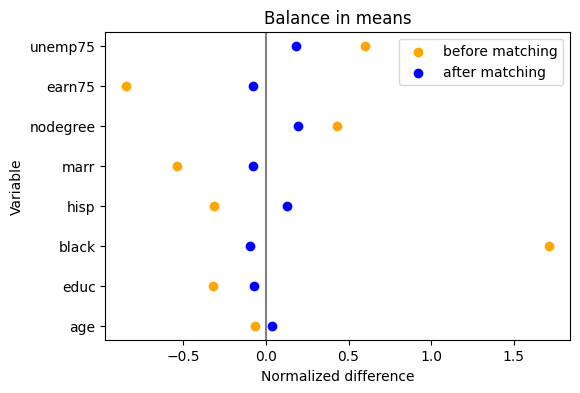

In [23]:
plot_balance(diff_means_norm, "Balance in means", "Normalized difference")

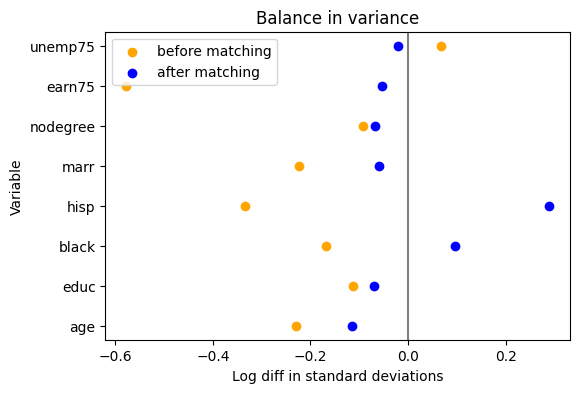

In [24]:
plot_balance(diff_log_stds, "Balance in variance", "Log diff in standard deviations")

### Appendix: Propensity score theorem
Assumptions
- conditional independence -- $(Y^1, Y^0) \perp\!\!\!\perp D | X $
- common support, so that we can estimate $E[Y^i | X_i = x]$ for all $x$ and for all $i$

Implication: conditioning on the propensity score is enough to recover the ATE $E[\delta_i (X_i)]$. Common support is necessary in order to estimate the propensity score, and conditional independence is necessary for the propensity score to be sufficient for controlling for all confounding.

Relation to the BLUE theorem in linear regression:
- conditioning on all the relevant indepdendent variables is enough to give you an unbiased estimate of $\beta$
- but, moreover, we have collapsed the matrix of Xs into a single number